In [7]:
import pandas as pd
import numpy  as np 
import os
import torch
import torch.nn as nn
import tensorflow as tf

In [79]:
#zip_path = tf.keras.utils.get_file(
#    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
#    fname='jena_climate_2009_2016.csv.zip',
#    extract=True)
csv_path='jena_climate_2009_2016.csv'
df = pd.read_csv(csv_path,)
df.drop('Unnamed: 0',axis=1,inplace=True)

device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [80]:
df=df[5::6]  # her 6 satırda bir veriyi gösteriyor.
df.index=pd.to_datetime(df['Date Time'],format='%d.%m.%Y %H:%M:%S')
df.columns
df.shape

<Axes: xlabel='Date Time'>

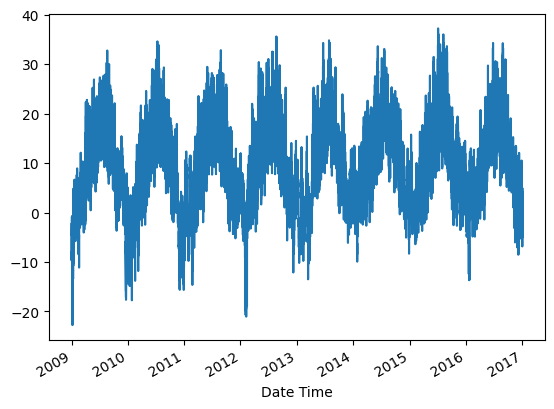

In [416]:
temp=df['T (degC)']
temp.plot()

In [417]:
def df_to_X_y (df,window_size=5):
    df_as_np=df.to_numpy()
    X=[]
    y=[]

    for i in range(len(df_as_np)-window_size):
        row=[ [a] for a in df_as_np[i:i+window_size]]
        X.append(row)
        label=df_as_np[i+window_size]
        y.append(label)
    return np.array(X),np.array(y)

X,y=df_to_X_y(temp,5)
X.shape,y.shape

((70086, 5, 1), (70086,))

#### Data split and turn to tensor and load dataloader

In [363]:
from torch.utils.data import DataLoader,TensorDataset

X_train,y_train=X[:60000],y[:60000]
X_val,y_val=X[60000:65000],y[60000:65000]
X_test,y_test=X[65000:],y[65000:]

X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

train_dataset=TensorDataset(torch.tensor(X_train,dtype=torch.float32),torch.tensor(y_train,dtype=torch.float32))
val_dataset=TensorDataset(torch.tensor(X_val,dtype=torch.float32),torch.tensor(y_val,dtype=torch.float32))
test_dataset=TensorDataset(torch.tensor(X_test).float(),torch.tensor(y_test).float())



train_dataloader=DataLoader(train_dataset,batch_size=64,shuffle=False)
val_dataloader=DataLoader(val_dataset,batch_size=64,shuffle=False)

train_dataset.tensors[0].shape,val_dataset.tensors[0].shape,test_dataset.tensors[0].shape

(torch.Size([60000, 5, 1]), torch.Size([5000, 5, 1]), torch.Size([5086, 5, 1]))

### Model With PyTorch

In [390]:
from torchsummary import summary
import matplotlib.pyplot as  plt
class CustomLSTM(nn.Module):
    def __init__(self,imput_size,hidden_size,output_size,num_layers):
        super (CustomLSTM,self).__init__()
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm=nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
        self.relu=nn.ReLU()
        self.fc1=nn.Linear(hidden_size,8)
        self.fc2=nn.Linear(8,output_size)


    def forward(self,x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out,_ =self.lstm(x,(h0,c0))
        out = self.relu(out[:, -1, :])
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)

        return out
    
def rmse(predictions, targets):
    mse = np.mean((predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [391]:
# for batch_idx,(input,target) in enumerate(train_dataloader):
#     print(batch_idx,input,target)
#     break
# input.shape

In [413]:
epochs=20
input_size = 1
hidden_size = 64
num_layers = 1
output_size=1
lr=0.0001
model = CustomLSTM(input_size, hidden_size, output_size,num_layers)
model.to(device)

criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


best_val_loss = float('inf')
train_pred_dict={}
val_pred_dict={}
for epoch in range(0,epochs) :

    model.train()
    loss_sum=0
    trainpred=[]
    trainact=[]
    for batch_idx,(input,target) in enumerate(train_dataloader):
        input=input.to(device)
        taget=target.to(device)
        pred=model(input)
        loss=criterion(pred,target)
        loss_sum+=loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainpred.append(np.array(pred.detach().flatten()))
        trainact.append(np.array(target.flatten()))
    train_pred_dict.update({epoch:[np.concatenate(trainpred),np.concatenate(trainact)]})
    score_pred =rmse(train_pred_dict[epoch][0],train_pred_dict[epoch][1])
    avg_train_loss=loss_sum/batch_idx


    model.eval()
    val_loss_sum=0
    valpred=[]
    valact=[]
    with torch.no_grad():
        for val_batch_idx,(val_input,val_target) in enumerate(val_dataloader):
            val_input=val_input.to(device)
            val_target=val_target.to(device)
            val_pred=model(val_input)
            val_loss=criterion(val_pred,val_target)
            val_loss_sum+=val_loss.item()
            valpred.append(np.array(val_pred.flatten()))
            valact.append(np.array(val_target.flatten()))

        val_pred_dict.update({epoch:[np.concatenate(valpred),np.concatenate(valact)]})
        score_val =rmse(val_pred_dict[epoch][0],val_pred_dict[epoch][1])
        avg_loss_val=val_loss_sum/val_batch_idx

        if avg_loss_val < best_val_loss:
            best_model_train_predict=train_pred_dict[epoch][0]
            best_model_train_target=train_pred_dict[epoch][1]
            best_model_val_predict=val_pred_dict[epoch][0]
            best_model_val_predict=val_pred_dict[epoch][1]


            checkpoint_dir='bestmodel/'
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)

            torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_model.pth'))
            best_val_loss = val_loss

        
    # if epoch%10 ==0 :
        # avg_loss=loss_sum/10
    print(f'{epoch} Train score {score_pred},train avg loss: {avg_train_loss},****** Val score : {score_val},val avg loss: {avg_loss_val}')
        


C:\Users\lenovothinkpad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lenovothinkpad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\lenovothinkpad\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra

0 Train score 11.898241996765137,train avg loss: 141.96166519621903,****** Val score : 7.326103687286377,val avg loss: 57.37186638208536
1 Train score 10.453118324279785,train avg loss: 110.09313597457768,****** Val score : 6.195980548858643,val avg loss: 42.05513660724346
2 Train score 9.180062294006348,train avg loss: 85.81198096116299,****** Val score : 5.150466442108154,val avg loss: 31.20133121502705
3 Train score 7.932413101196289,train avg loss: 65.70665314173368,****** Val score : 4.2496018409729,val avg loss: 24.123313008210598
4 Train score 6.783926963806152,train avg loss: 50.2264111423696,****** Val score : 3.5267062187194824,val avg loss: 19.95657030130044
5 Train score 5.792750358581543,train avg loss: 39.13681607070829,****** Val score : 3.01175856590271,val avg loss: 17.823143690060345
6 Train score 4.990972995758057,train avg loss: 31.752507233759637,****** Val score : 2.690298557281494,val avg loss: 16.964258059477196
7 Train score 4.355950832366943,train avg loss: 27

In [414]:
train_results = pd.DataFrame(data={'Train Predictions':best_model_train_predict, 'Actuals':best_model_train_target})
train_results

,Train Predictions,Actuals
0,-4.402558,-9.67
1,-4.422078,-9.17
2,-4.419422,-8.10
3,-4.401745,-7.66
4,-4.384354,-7.04
...,...,...
59995,3.806949,6.07
59996,5.270194,9.88
59997,7.732562,13.53
59998,10.654698,15.43


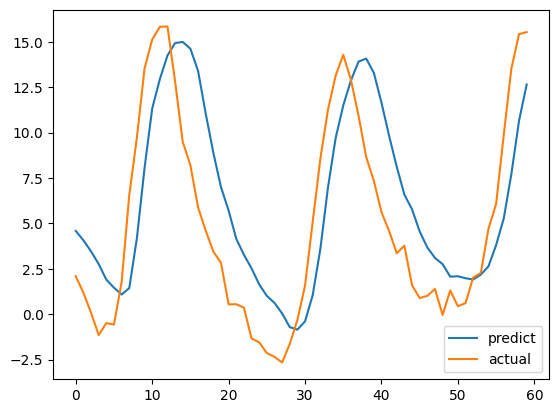

In [415]:
plt.plot(best_model_train_predict[-60:],label='predict')
plt.plot(best_model_train_target[-60:],label='actual')
plt.legend()  # Etiketleri grafiğe ekleme
plt.show()

In [244]:
# Kaydedilmiş ağırlıkları yükleme
model.load_state_dict(torch.load(os.path.join(checkpoint_dir, 'best_model.pth')))
X_train_tensor =train_dataset.tensors[0].cpu().flatten().unsqueeze(0)
X_train_tensor = X_train_tensor.view(-1, 5, 1)
model.eval()  # Modeli değerlendirme moduna ayarlama
with torch.no_grad():  # Gradyan hesaplamalarını kapatma
    train_predictions_tensor = model(X_train_tensor)
train_predictions = train_predictions_tensor.cpu().numpy().flatten()  # NumPy array'e dönüştürme

# Tahminleri ve gerçek değerleri bir DataFrame'e dönüştürme
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train})

print(train_results)

       Train Predictions  Actuals
0               9.286412    -9.67
1               9.286713    -9.17
2               9.285810    -8.10
3               9.285237    -7.66
4               9.286103    -7.04
...                  ...      ...
59995           9.417760     6.07
59996           9.427279     9.88
59997           9.512588    13.53
59998           9.575821    15.43
59999           9.584822    15.54

[60000 rows x 2 columns]
